<a href="https://colab.research.google.com/github/nulllpointer/custom_object_detection_colab/blob/master/objdet_custom_tf_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Tensorflow Object Detection with custom dataset in Google Colab

Jupyter notebook providing steps to retrain a [ModelZoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) model with custom dataset.

It runs in [Google Colab](https://colab.research.google.com) using [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).

**Requirements are only dataset images and annotations file.**

The code is compatible with Object Detection api updates in July 13 2018 [release](https://github.com/tensorflow/models/tree/master/research/object_detection#july-13-2018).

**Colab Runtime type: Python2, GPU enabled.**



# Install required packages


In [16]:
import os


%cd
#  run initially 
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

%cd ~/models/research

!protoc object_detection/protos/*.proto --python_out=.

os.environ['PYTHONPATH'] += ':/root/models/research/:/root/models/research/slim'

!python object_detection/builders/model_builder_test.py

/root
fatal: destination path 'models' already exists and is not an empty directory.
/root/models/research
W0728 20:13:05.378731 140676482783104 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0728 20:13:05.544301 140676482783104 deprecation_wrapper.py:119] From /root/models/research/slim/nets/inception_resnet_v2.py:373: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0728 20:13:05.578058 140676482783104 deprecation_wrapper.py:119] From /root/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

Running tests under Python 2.7.15: /usr/bin/python2

In [35]:
from google.colab import files
from os import path
%mkdir -p ~/datalab 
%cd ~/datalab
uploaded = files.upload()  
for name, data in uploaded.items():
  with open('label_map.pbtxt', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)
!cat ~/datalab/label_map.pbtxt    
    
    

/root/datalab


Saving label_map.pbtxt to label_map.pbtxt
saved file label_map.pbtxt
item {
  id: 1
  name: 'numberplate'
}






import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Download and extract dataset


*   Change name attribute in label_map, accordingly with objectclass filename.
*   Substitute fileId value with your dataset.zip id in Google Drive. See [here](https://stackoverflow.com/a/48855034/9250875) my answer to get file id.

In [17]:
import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


"""creates a directory and downloads the datalset from gdrive"""

%cd ~/datalab

fileId = '1rtChiD59mt2p93zU34DN_OSYgnza6reG'
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)

image_files=os.listdir('images')
im_files=[x.split('.')[0] for x in image_files]
with open('annotations/trainval.txt', 'w') as text_file:
  for row in im_files:
    text_file.write(row + '\n')

/root/datalab


W0728 20:13:44.562400 140405032851328 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 41, in autodetect
    from . import file_cache
  File "/usr/local/lib/python2.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    'file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth')
ImportError: file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth


Extracted zip file 1rtChiD59mt2p93zU34DN_OSYgnza6reG.zip


#Empty png files
Create empty png mask files to avoid error in create_pet_tf_record.py, they are not used in training model.

In [18]:
from PIL import Image


%cd ~/datalab/annotations
!mkdir -p trimaps
image = Image.new('RGB', (640, 480))

for filename in os.listdir('xmls'):
  filename = os.path.splitext(filename)[0]
  image.save('trimaps/' + filename + '.png')

/root/datalab/annotations


# Create TFRecord

In [19]:
%cd ~/datalab

!python ~/models/research/object_detection/dataset_tools/create_pet_tf_record.py --label_map_path=label_map.pbtxt --data_dir=. --output_dir=. --num_shards=1

!mv pet_faces_train.record-00000-of-00001 tf_train.record

!mv pet_faces_val.record-00000-of-00001 tf_val.record


/root/datalab
W0728 20:14:46.443897 140226844211072 deprecation_wrapper.py:119] From /root/models/research/object_detection/dataset_tools/create_pet_tf_record.py:318: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W0728 20:14:46.444993 140226844211072 deprecation_wrapper.py:119] From /root/models/research/object_detection/utils/label_map_util.py:137: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

I0728 20:14:46.451565 140226844211072 create_pet_tf_record.py:273] Reading from Pet dataset.
I0728 20:14:46.485687 140226844211072 create_pet_tf_record.py:288] 5175 training and 2218 validation examples.
W0728 20:14:46.485949 140226844211072 deprecation_wrapper.py:119] From /root/models/research/object_detection/dataset_tools/tf_record_creation_util.py:43: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

I0728 20:14:46.486315 140226844211072 create_pet_tf_record.py:241] On image 0 of 5175




# Download pretrained model

Cell downloads **faster_rcnn_inception_v2_coco** model to use as starting checkpoint.

To use another model from ModelZoo change MODEL var.

In [20]:
import os
import shutil
import glob
import urllib
import tarfile


# Get list of models from https://github.com/tensorflow/models/blob/fe748d4a4a1576b57c279014ac0ceb47344399c4/research/object_detection/g3doc/detection_model_zoo.md

%cd ~/datalab
MODEL= 'ssd_inception_v2_coco_2018_01_28'
# MODEL = 'ssd_mobilenet_v2_coco_2018_03_29'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  opener = urllib.URLopener()
  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()
os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)












/root/datalab


# Edit model config file
To you use a different pretrained model in step before, update accordingly filename var and re.sub functions in next cell.


In [0]:
# import re

# %cd ~


# PATH_TO_BE_CONFIGURED='~/datalab'

# # filename = '/root/models/research/object_detection/samples/configs/faster_rcnn_inception_v2_pets.config'

# filename = '/root/models/research/object_detection/samples/configs/ssd_inception_v2_pets.config'

# with open(filename) as f:
#   s = f.read()
# with open(filename, 'w') as f:
#   s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/root/datalab/pretrained_model/model.ckpt', s)
#   s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_train.record-\?\?\?\?\?-of-00010', '/root/datalab/tf_train.record', s)
#   s = re.sub('PATH_TO_BE_CONFIGURED/pet_faces_val.record-\?\?\?\?\?-of-00010', '/root/datalab/tf_val.record', s)
#   s = re.sub('PATH_TO_BE_CONFIGURED/pet_label_map.pbtxt', '/root/datalab/label_map.pbtxt', s)
#   f.write(s)
  
# #   s = re.sub('fixed_shape_resizer', 'keep_aspect_ratio_resizer', s)
# #   s = re.sub('height\: 300', 'min_dimension: 300', s)
# #   s = re.sub('width\: 300', 'max_dimension: 300', s)

# # pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
# # with tf.gfile.GFile(filename, "r") as f:
# #   proto_str = f.read()                                                                                                                                                                                                                                          
# #   text_format.Merge(proto_str, pipeline_config)                                                                                                                                                                                                                 

# # pipeline_config.model.ssd.image_resizer.fixed_shape_resizer.height = 200                                                                                                                                                                                          
# # pipeline_config.model.ssd.image_resizer.fixed_shape_resizer.width = 300                                                                                                                                                                                           

# # config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
# # with tf.gfile.Open('ssd_inception_v2_pets.config', "wb") as f:                                                                                                                                                                                                                       
# #         f.write(config_text)    
  
  
  
  
  


  
  
# !cat /root/models/research/object_detection/samples/configs/ssd_inception_v2_pets.config

In [15]:
import tensorflow as tf
import os
from google.protobuf import text_format
from object_detection.protos import pipeline_pb2


# !cat /root/models/research/object_detection/samples/configs/ssd_inception_v2_pets.config
!cp -r ~/models/research/object_detection /usr/local/lib/python2.7/dist-packages/

filename = '/root/models/research/object_detection/samples/configs/ssd_inception_v2_pets.config'

pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()                                                                                                                                                                                                          

with tf.gfile.GFile(filename, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)                                                                                                                                                                                                                 

pipeline_config.model.ssd.image_resizer.fixed_shape_resizer.height = 300                                                                                                                                                                                          
pipeline_config.model.ssd.image_resizer.fixed_shape_resizer.width = 300




pipeline_config.train_config.batch_size = 32
pipeline_config.train_config.fine_tune_checkpoint = '/root/datalab/pretrained_model/model.ckpt'
pipeline_config.train_input_reader[0].label_map_path = '/root/datalab/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[0] = '/root/datalab/tf_train.record'
pipeline_config.eval_input_reader[0].label_map_path = '/root/datalab/label_map.pbtxt'
pipeline_config.eval_input_reader.tf_record_input_reader.input_path[0] = '/root/datalab/tf_val.record'
    


config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.gfile.Open(filename, "wb") as f:                                                                                                                                                                                                                       
    f.write(config_text)                                                                                                                                                                                                                                          


!cat /root/models/research/object_detection/samples/configs/ssd_inception_v2_pets.config

TypeError: ignored

# Train model
Set num_train_steps and num_eval_steps values to change train and eval steps in training process.



In [0]:
%cd ~/datalab
!pwd
import tensorflow as tf




PATH_TO_BE_CONFIGURED='~/datalab'

!python ~/models/research/object_detection/model_main.py \
    --pipeline_config_path=/root/models/research/object_detection/samples/configs/ssd_inception_v2_pets.config \
    --model_dir=/root/datalab/trained \
    --alsologtostderr \
    --num_train_steps=3000 \
    --num_eval_steps=1000

# writer=tf.summary.FileWriter('logs')
# writer.add_graph(tf.get_default_graph())
# writer.flush()

# %load_ext tensorboard
# # %reload_ext tensorboard
# # %tensorboard --logdir {logs_base_dir}

# %tensorboard --logdir .





In [0]:
!ls /root/datalab/trained

#Export trained model

Export trained model with highest step number in filename.

In [0]:
# !rm -r ~/datalab/fine_tuned_model

%cd ~/datalab

lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
print(lf)

last_model = sorted(lf)[-1].replace('.meta', '')
!python ~/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/root/models/research/object_detection/samples/configs/ssd_inception_v2_pets.config \
    --output_directory=fine_tuned_model \
    --trained_checkpoint_prefix=trained/$last_model







In [0]:
# For TF lite

%cd ~/datalab
lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
print(lf)

last_model = sorted(lf)[-1].replace('.meta', '')
!python ~/models/research/object_detection/export_tflite_ssd_graph.py \
    --pipeline_config_path=/root/models/research/object_detection/samples/configs/ssd_inception_v2_pets.config \
    --trained_checkpoint_prefix=trained/$last_model \
    --output_directory=tflite_fine_tuned_model \
    --max_detections 3

#Upload jpg image for inference

In [32]:
%cd ~/datalab

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)
    
    
# im = Image.open('image1.jpg')
# new_width  = 600
# new_height = 400
# im = im.resize((new_width, new_height), Image.ANTIALIAS)
# im.save('image1.jpg')




/root/datalab


Saving download (1).jpeg to download (1).jpeg
saved file download (1).jpeg


# Run inference


/root/models/research/object_detection
hero


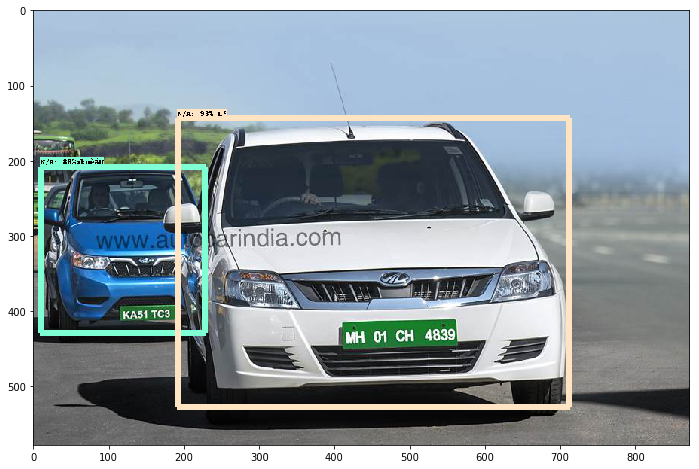

In [36]:
%cd ~/models/research/object_detection




import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

# if tf.__version__ < '1.4.0':
#   raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
  

  
  
# This is needed to display the images.
%matplotlib inline




from utils import label_map_util

from utils import visualization_utils as vis_util



# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/root/datalab/fine_tuned_model' + '/frozen_inference_graph.pb'


PATH_TO_CKPT = '/root/datalab/ssd_mobilenet_v1_coco_2018_01_28' + '/frozen_inference_graph.pb'






# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/root/datalab', 'label_map.pbtxt')

NUM_CLASSES = 37




detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    
    
    
print('hero')
    
with tf.Session() as sess:
  # `sess.graph` provides access to the graph used in a `tf.Session`.
  writer = tf.summary.FileWriter("./hero", sess.graph)    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)




def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/root/datalab/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)




def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
        
  return output_dict



for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  

In [0]:
%cd ~
!zip -r /root/newfile.zip /root/datalab/pretrained_model

from google.colab import files
files.download('/root/newfile.zip')


# # !rm -r /root/datalab




# import tensorflow as tf


# LOG_DIR = '/root/datalab/pretrained_model'



# !tensorboard --logdir=LOG_DIR


# get_ipython().system_raw(
#     'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#     .format(LOG_DIR)
# )


# get_ipython().system_raw('./ngrok http 6006 &')
# # One last step, we get the public URL where we can access the colab TensorBoard web page.

# !curl -s http://localhost:4040/api/tunnels | python3 -c \
#     "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

In [0]:

%cd ~/datalab

LOGDIR = '/root/datalab/pretrained_model'



#Todo
import tensorflow as tf
from tensorflow.python.platform import gfile
with tf.Session() as sess:
    model_filename ='/root/datalab/fine_tuned_model/frozen_inference_graph.pb'
    with gfile.FastGFile(model_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
        g_in = tf.import_graph_def(graph_def)
LOGDIR='/root/datalab/fine_tuned_model'
train_writer = tf.summary.FileWriter(LOGDIR)
train_writer.add_graph(sess.graph)





In [31]:
# %cd ~
# !rm -r *

# import fnmatch

# image_count= len(fnmatch.filter(os.listdir('/root/datalab/images'), '*.jpg'))
# batch=image_count/24
# print(str(batch))


# %cd ~/datalab
# !unzip newfile.zip 


# import os
# from zipfile import ZipFile



# %cd ~/datalab
# !ls
# fileName = 'newfile.zip'
# ds = ZipFile(fileName)
# ds.extractall()
# os.remove(fileName)
# print('Extracted zip file ' + fileName)


# from google.colab import files
# from os import path
# %cd ~/datalab
# uploaded = files.upload()  
# for name, data in uploaded.items():
#   with open('label_map.pbtxt', 'wb') as f:
#     f.write(data)
#     f.close()
#     print('saved file ' + name)
# !cat ~/datalab/label_map.pbtxt    





%cd ~/datalab

fileId = '1Vbfi526XYACfvgTZl-V9n1qtoO3lF3cl'
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
ds = ZipFile(fileName)
ds.extractall()
os.remove(fileName)
print('Extracted zip file ' + fileName)


W0728 20:43:25.631547 140405032851328 __init__.py:44] file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth
Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/googleapiclient/discovery_cache/__init__.py", line 41, in autodetect
    from . import file_cache
  File "/usr/local/lib/python2.7/dist-packages/googleapiclient/discovery_cache/file_cache.py", line 41, in <module>
    'file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth')
ImportError: file_cache is unavailable when using oauth2client >= 4.0.0 or google-auth


/root/datalab
Extracted zip file 1Vbfi526XYACfvgTZl-V9n1qtoO3lF3cl.zip
